Projekt dotyczy analizy danych zawartych w zbiorze dotyczącym słuchotek, inaczej nazywanych uchowcami. W ramach projektu dla wybranego zbioru danych wykonano macierz korelacji, wykonano regresję za pomocą drzewa decyzyjnego, regresję liniową, regresję typu Random Forest oraz w celu otrzymania dla każdego uchowca liczbę pierścieni. Wykonana została także klasyfikacja z wykorzystaniem drzewa decyzyjnego oraz metody Random Forest.

Zbiór danych uwzględnia wiek, długość, średnicę, wysokość, całkowitą masę, masę mięsa, masę wnętrzności, masę muszli
i liczbę pierścieni.


Używam bibliotek:

In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np

from ucimlrepo import fetch_ucirepo
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from tabulate import tabulate

Pobieram dane:

In [140]:
abalone = fetch_ucirepo(id=1) 
X = abalone.data.features 
y = abalone.data.targets 
X

Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
0      M   0.455     0.365   0.095        0.5140          0.2245   
1      M   0.350     0.265   0.090        0.2255          0.0995   
2      F   0.530     0.420   0.135        0.6770          0.2565   
3      M   0.440     0.365   0.125        0.5160          0.2155   
4      I   0.330     0.255   0.080        0.2050          0.0895   
...   ..     ...       ...     ...           ...             ...   
4172   F   0.565     0.450   0.165        0.8870          0.3700   
4173   M   0.590     0.440   0.135        0.9660          0.4390   
4174   M   0.600     0.475   0.205        1.1760          0.5255   
4175   F   0.625     0.485   0.150        1.0945          0.5310   
4176   M   0.710     0.555   0.195        1.9485          0.9455   

      Viscera_weight  Shell_weight  
0             0.1010        0.1500  
1             0.0485        0.0700  
2             0.1415        0.2100  
3             0.1140        0.1550  
4             0.0395        0.0550  
...              ...           ...  
4172          0.2390        0.2490  
4173          0.2145        0.2605  
4174          0.2875        0.3080  
4175          0.2610        0.2960  
4176          0.3765        0.4950  

[4177 rows x 8 columns]

Tworzę wykresy obrazujące relacje pomiędzy parametrami:

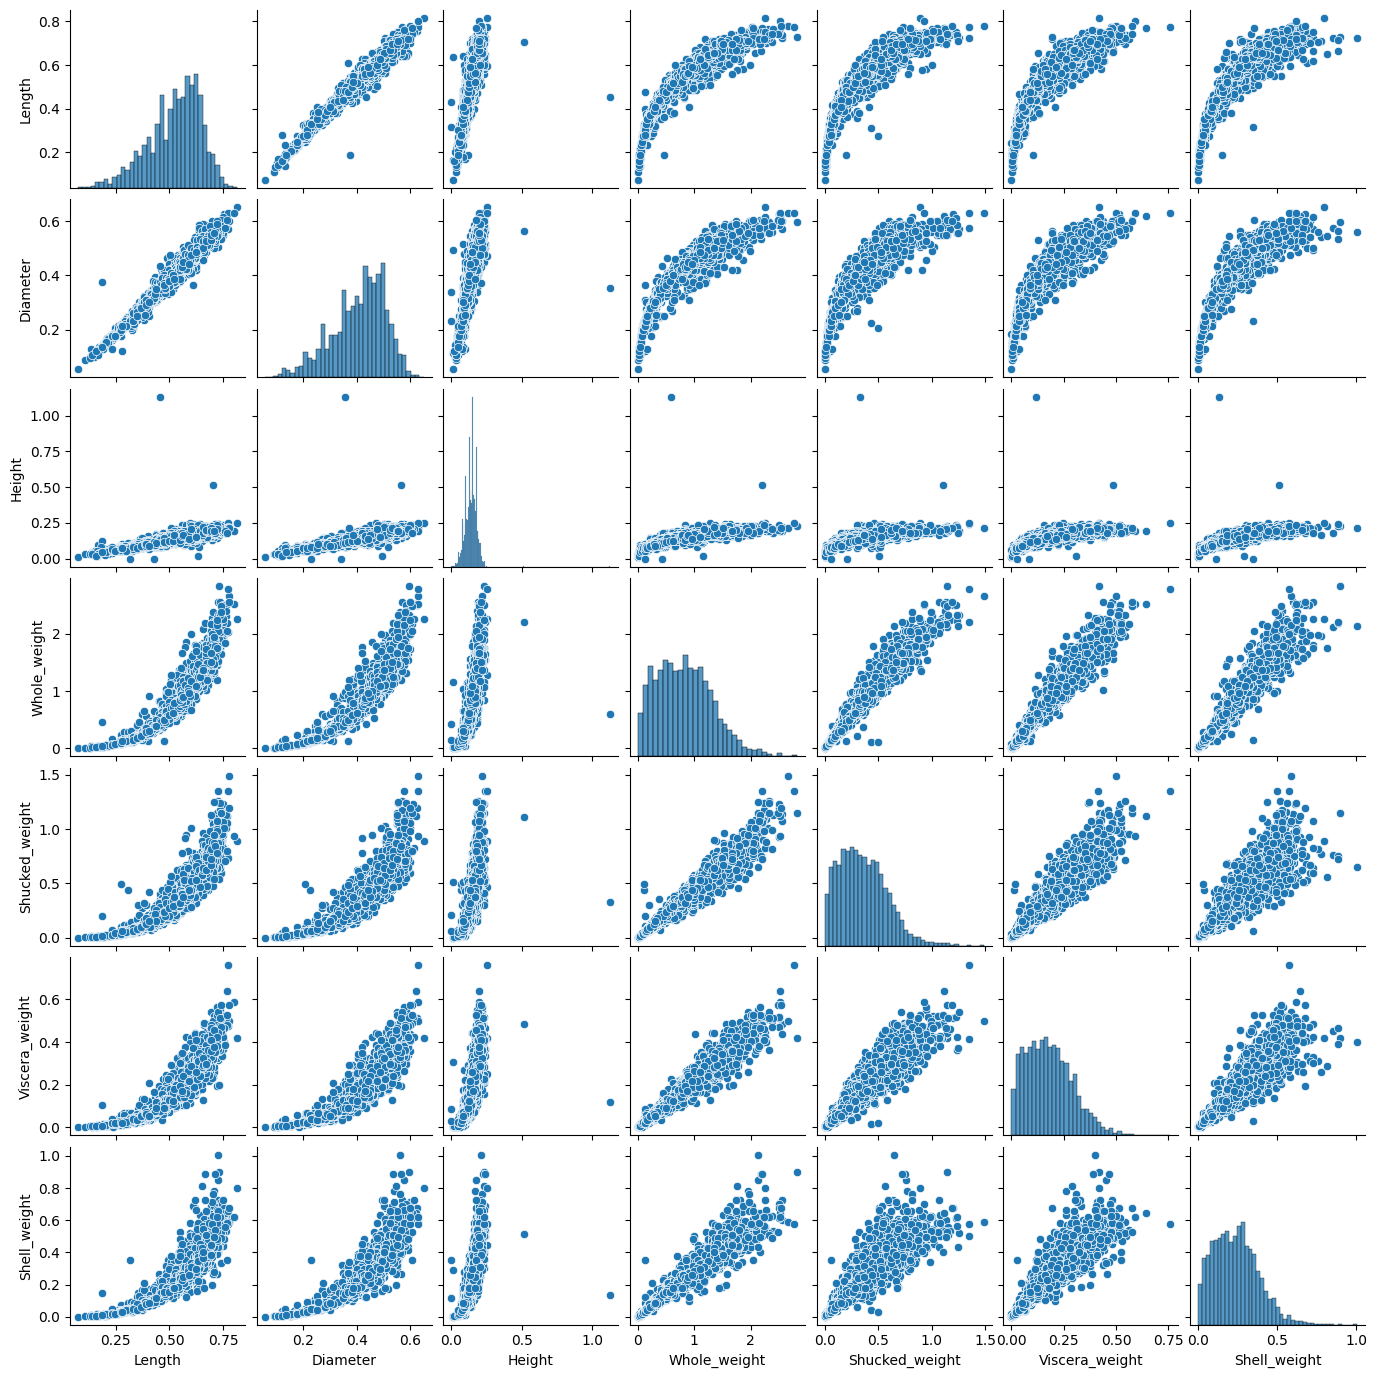

In [135]:
columns=['Length', 'Diameter', 'Height', 'Whole_weight',
         'Shucked_weight','Viscera_weight', 'Shell_weight']
sns.pairplot(X[columns],height=2,kind='scatter')
plt.show()


Z powyższych wykresów można wywnioskować,że wszystkie parametry mają wpływ na wartości pozostałych parametrów.


Tworzę rozkład liczby pierścieni:

Text(0, 0.5, 'Liczba wystąpień')

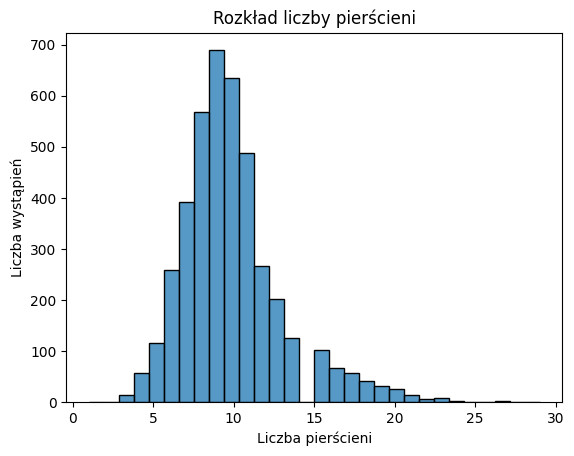

In [154]:
sns.histplot(y['Rings'],bins=30, kde=False)
plt.title('Rozkład liczby pierścieni')
plt.xlabel('Liczba pierścieni')
plt.ylabel('Liczba wystąpień')

Z otrzymanego wykresu możemy wywnioskować, że najwięcej próbek posiada od 8 do 11 pierścieni.

Tworzę macierz korelacji:

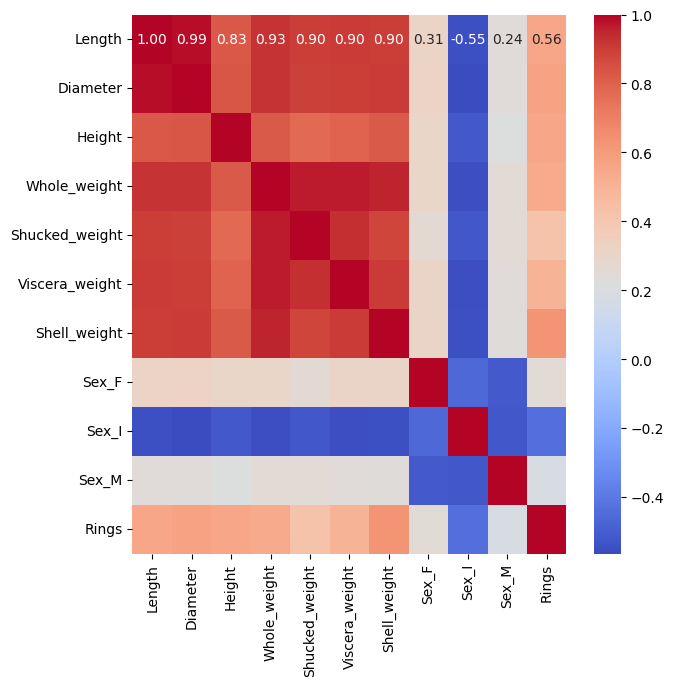

In [4]:
columns_to_hot_encode = []
for col in X:
    if (X[col].dtype == 'object'):
        columns_to_hot_encode.append(col)
        
features = pd.get_dummies(X, columns=columns_to_hot_encode)
C = pd.concat([features, y], axis=1)
c_matrix = C.corr()
plt.figure(figsize=(7, 7))
sns.heatmap(c_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

Z otrzymanej macierzy korelacji, możemy wywnioskować, że wszystkie parametry są ze sobą mocno skorelowane.

Na podstawie dostępnych parametrów dokonamy regresji (oszacowania wartości na podstawie innych charakterystyk) liczby pierścieni jaką ma dana muszla.

In [15]:
X = features.values.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=49)
model = DecisionTreeRegressor(random_state = 50)
model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=50)

Tworzę drzewo decyzyjne dla regresji:

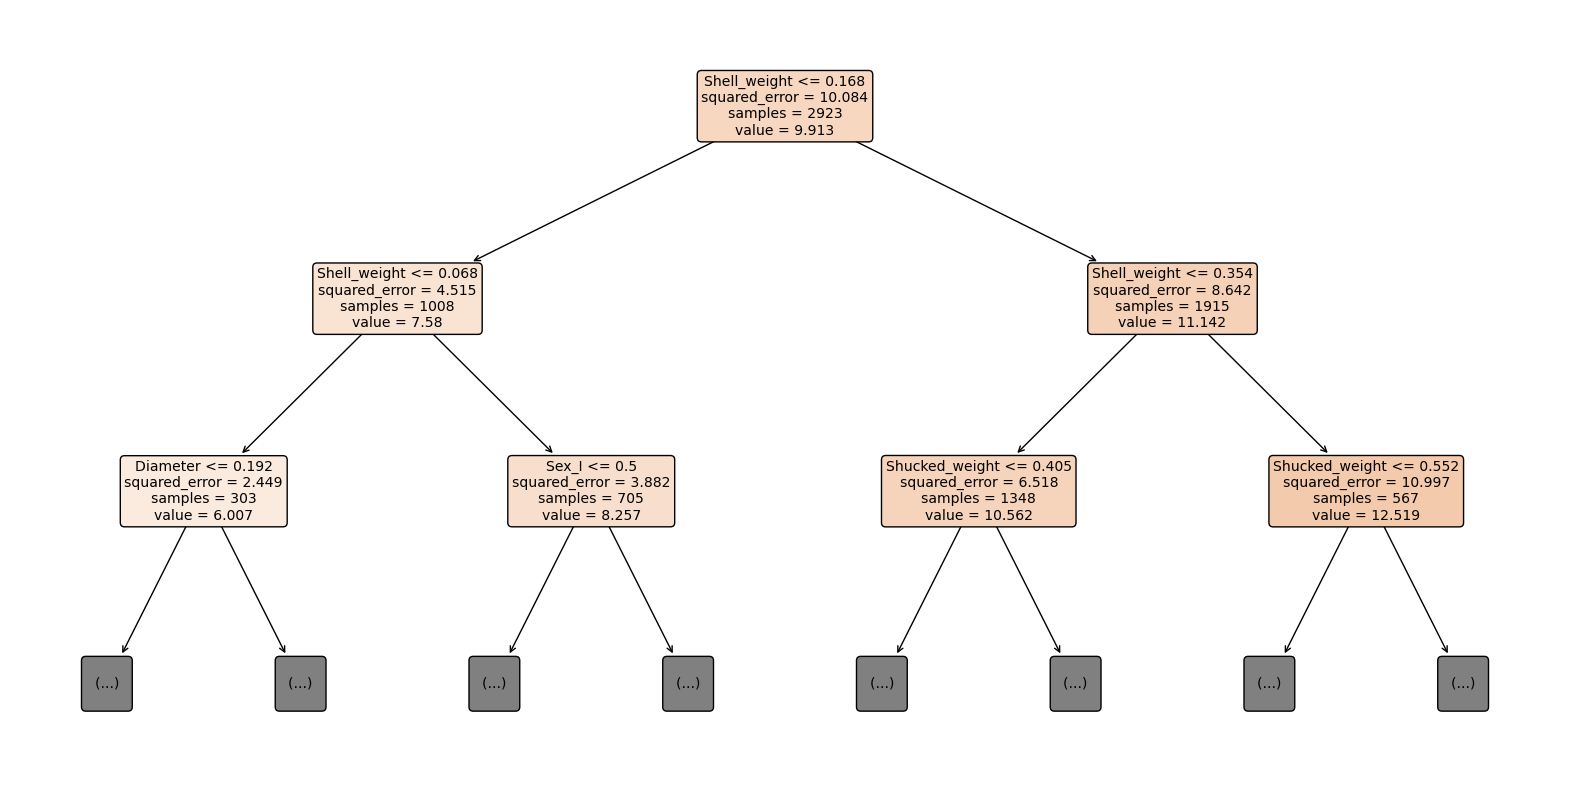

In [16]:
plt.figure(figsize=(20, 10))
columns = features.columns
plot_tree(model, filled=True, rounded=True, feature_names=columns, max_depth=2)
plt.show()

Ze względu na czytelność, drzewo zostało ograniczone do 2 poziomów. Z każdym poziomem maleje wartość błędu średniokwadratowego, ale można zauważyć większy spadek przy wyborze lewej ścieżki. W korzeniu drzewa błąd średniokwadratowy wyniósł 10.084, natomiast w ostatnich z rozważanych poziomów wyniosły odpowiednio: 2.449, 3.882, 6.518 i 10.997.  
W korzeniu drzewa wybrane zostały 2923 próbki i przewidziano wartość 9.913. W prawej ścieżce rozważanych jest więcej próbek niż na lewej oraz osiągane są większe przewidywane wartości. 
Na prawej ścieżce wybory podejmowane są na podstawie masy muszli lub masy mięsa, zaś na lewej ścieżce na podstawie masy muszli, średnicy i płci.

Definiuję funkcję do tworzenia wykresu przedstawiającego wynik regresji:

In [57]:
def plot_regression_result(target_y, predicted_y, title=''):
    fig, ax = plt.subplots(figsize=(5,5))
    if isinstance(target_y, pd.DataFrame):
        target_y = target_y.squeeze()
    if isinstance(predicted_y, pd.DataFrame):
        predicted_y = predicted_y.squeeze()
    ax.plot(target_y, predicted_y, '.r')
    ax.plot([0, 40], [0, 40], '--k')
    ax.text(37,
            2,
            "Błąd średniokwadratowy= %.2g" % ((target_y - predicted_y).std()),
            ha='right',
            va='bottom'
           )
    ax.set_xlim(0, 40)
    ax.set_ylim(0, 40)
    ax.set_xlabel('Prawdziwa liczba pierścieni')
    ax.set_ylabel('Przewidziana liczba pierścieni')
    ax.set_title(title)

Tworzę wykresy wyników regresji dla zbioru testowego i treningowego dla wyuczonego modelu:

Uzyskana dokładność przybliżenia:  0.16506004069111713


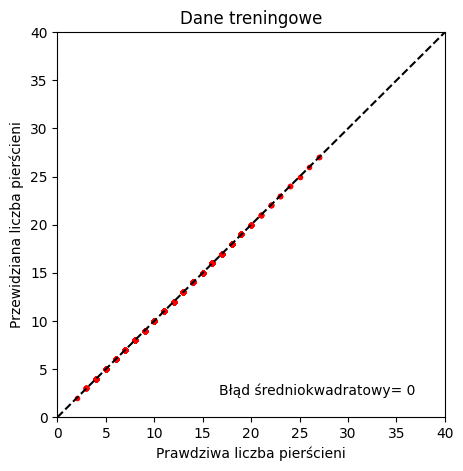

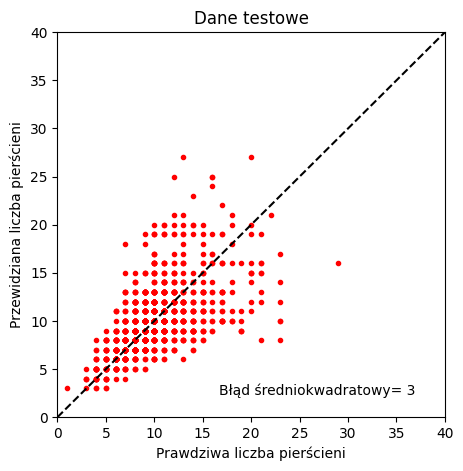

In [80]:
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
print('Uzyskana dokładność przybliżenia: ', model.score(X_test, y_test))
plot_regression_result(y_train, y_train_pred, 'Dane treningowe')
plot_regression_result(y_test, y_test_pred, 'Dane testowe')

Na podstawie otrzymanych wykresów można zauważyć, że estymator przewiduje wartości dla danych treningowych z błędem średniokwadratowym równym 0, natomiast dla danych testowych wynosi on już 3. Wyniki dla danych testowych są bardzo rozrzucone. Można stąd wywnioskować, że estymator jest przeuczony dla zestawu danych treningowych i nie potrafi poprawnie przewidzieć wartości dla danych testowych. Uzyskana dokładność przybliżenia wyniosła 16%. W celu poprawienia tego problemu, wykonane zostanie regresja liniowa, regresja Random Forest, ograniczenie liczby poziomów dla regresyjnego drzewa decyzyjnego.

Tworzę identyczny model do poprzedniego, tym razem z ograniczoną głębokością drzewa:

Uzyskana dokładność przybliżenia:  0.48819420555783566


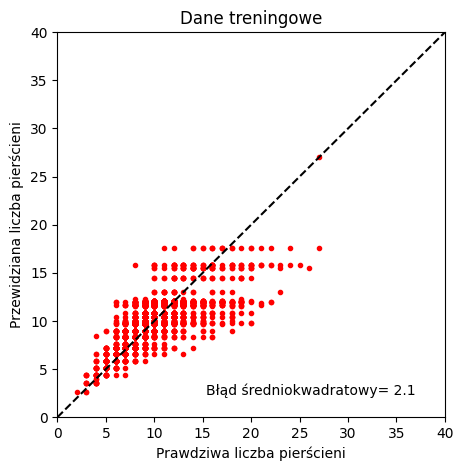

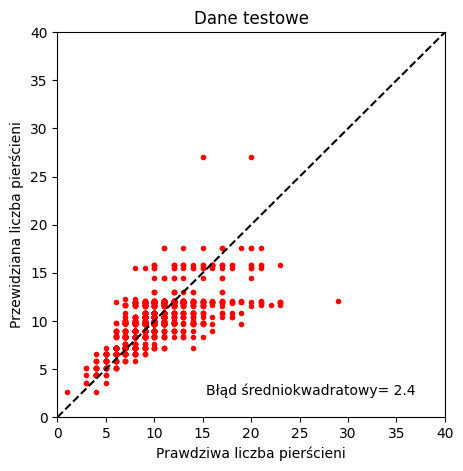

In [90]:
model = DecisionTreeRegressor(max_depth=5)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
print('Uzyskana dokładność przybliżenia: ', model.score(X_test, y_test))
plot_regression_result(y_train, y_train_pred, 'Dane treningowe')
plot_regression_result(y_test, y_test_pred, 'Dane testowe')

Po ograniczeniu głębokości drzewa zwiększył się błąd średniokwadratowy dla danych treningowych do wartości 2.1, natomiast dla danych testowych zwiększył się do 2.4. Uzyskana dokładność precyzji wyniosła 49%.

Wykonuję regresję liniową:

Uzyskana dokładność przybliżenia:  0.5334181276512535


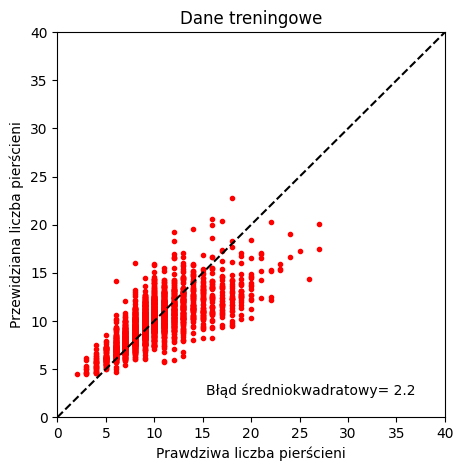

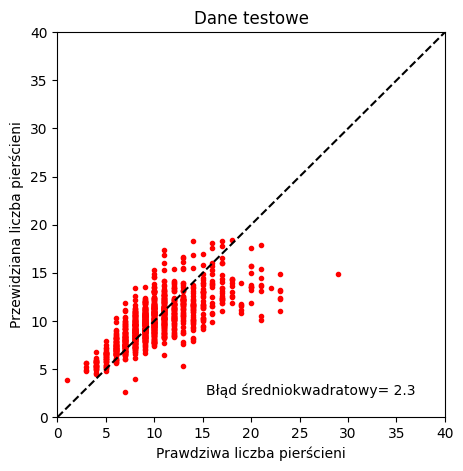

In [79]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
y_test_pred = lin_reg_model.predict(X_test).flatten()
y_train_pred = lin_reg_model.predict(X_train).flatten()
print('Uzyskana dokładność przybliżenia: ', lin_reg_model.score(X_test, y_test))
plot_regression_result(y_train, y_train_pred, 'Dane treningowe')
plot_regression_result(y_test, y_test_pred, 'Dane testowe')

Przy użyciu regresji liniowej różnica pomiędzy błędem średniokwadratowym dla zestawu testowego a zestawu treningowego wynosi 0.1. Uzyskana dokładność przybliżenia wyniosła 53%.

Wykonuję regresję Random Forest:

Uzyskana dokładność przybliżenia:  0.5124114295055933


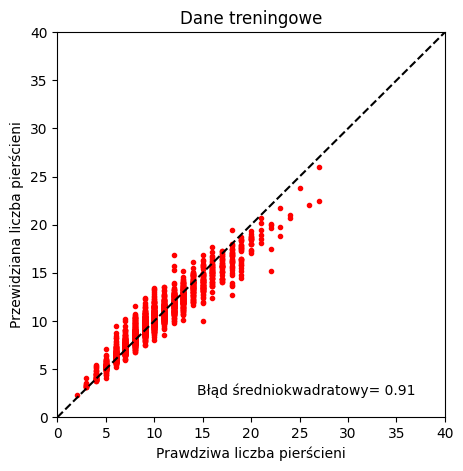

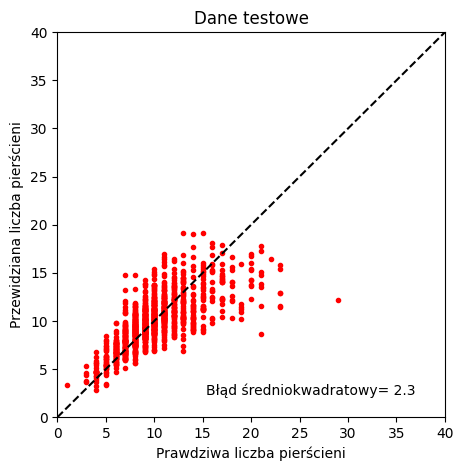

In [78]:
rand_forest_reg_model = RandomForestRegressor(n_estimators=10)
rand_forest_reg_model.fit(X_train, y_train.values.ravel())
print('Uzyskana dokładność przybliżenia: ', rand_forest_reg_model.score(X_test, y_test))
y_test_pred = rand_forest_reg_model.predict(X_test).flatten()
y_train_pred = rand_forest_reg_model.predict(X_train).flatten()
plot_regression_result(y_train, y_train_pred, 'Dane treningowe')
plot_regression_result(y_test, y_test_pred, 'Dane testowe')

Dla regresji Random Forest udało się uzyskać błąd średniokwadratowy dla danych treningowych na poziomie 0.95, zaś dla danych testowych 2.3 podobnie jak w przypadku regresji liniowej. Zwiększanie liczby estymatorów zmniejsza wartość błędu dla danych treningowych, ale nie udało się zmniejszyć poniżej 2.2 dla danych testowych. Uzyskana dokładność przybliżenia wyniosła 51%.

Wykonuje klasyfikację za pomocą drzewa decyzyjnego:

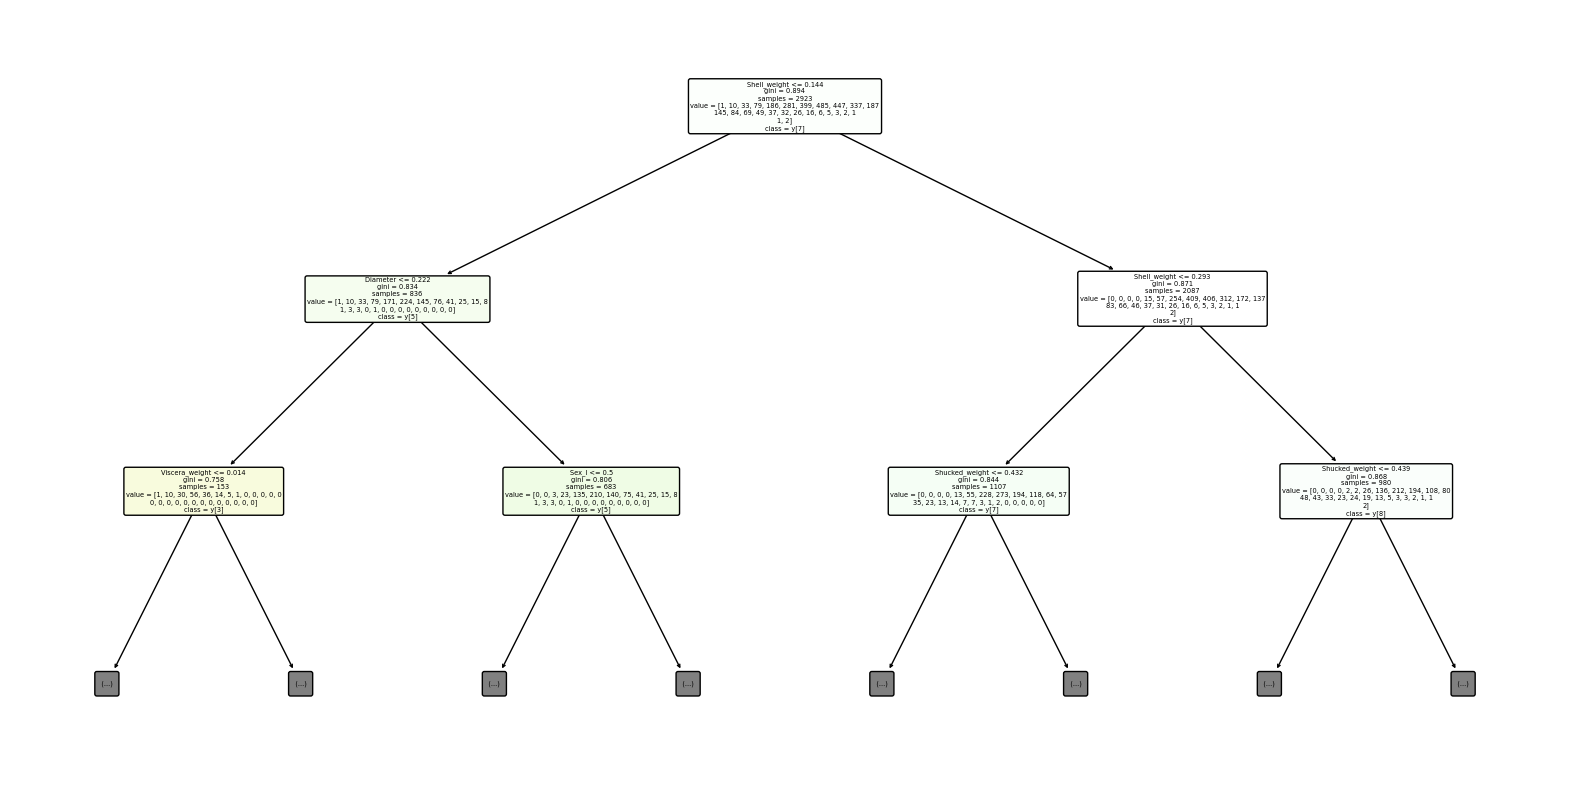

Uzyskana dokładność przybliżenia:  0.20414673046251994


In [117]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
plt.figure(figsize=(20,10))
plot_tree(dt_classifier,
          filled=True,
          rounded=True,
          class_names=True,
          feature_names=columns,
          max_depth=2
         )
plt.show()
print('Uzyskana dokładność przybliżenia: ', dt_classifier.score(X_test, y_test))

Klasyfikacja drzewem decyzyjnym przewiduje liczbę pierścieni z 20% dokładnością. Korzeń drzewa wybrał 2923 próbek, które miały masę muszli <= 0.144, ponieważ masa muszli została wybrana do korzenia drzewa, możemy założyć, że jest cechą dostarczającą najwięcej informacji. Węzły na następnych poziomach określały wybór na podstawie masy muszli i masy mięsa na prawej ścieżce oraz na podstawie średnicy, płci i masy wnętrzności na lewej ścieżce. Wartość indeksu Gini jest większa na prawej ścieżce.

Wykonuję klasyfikację za pomocą metody Random Forest:

In [127]:
rf_classifier = RandomForestClassifier(n_estimators=50)
flat_y_train = y_train.values.ravel()
rf_classifier.fit(X_train, flat_y_train)
print('Uzyskana dokładność przybliżenia: ', rf_classifier.score(X_test, y_test))

Uzyskana dokładność przybliżenia:  0.23444976076555024


Wykorzystując klasyfikator RandomForest udało się otrzymać dokładność przybliżenia równą: 23%.

Podsumowanie:
